In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
train_dir = "../Dataset/train"
test_dir = "../Dataset/test1"
val_dir = "../Dataset/validation"

print("Jumlah kelas train:", len(os.listdir(train_dir)))
print("Jumlah kelas test:", len(os.listdir(test_dir)))
print("Jumlah kelas val:", len(os.listdir(val_dir)))

# Hitung jumlah file pada setiap folder dalam train, test, dan val direktori



for folder in os.listdir(train_dir):
    print(f"[TRAIN] {folder}: {len(os.listdir(os.path.join(train_dir, folder)))} file")
for folder in os.listdir(test_dir):
    print(f"[TEST] {folder}: {len(os.listdir(os.path.join(test_dir, folder)))} file")
for folder in os.listdir(val_dir):
    print(f"[VAL] {folder}: {len(os.listdir(os.path.join(val_dir, folder)))} file")

Jumlah kelas train: 4
Jumlah kelas test: 4
Jumlah kelas val: 4
[TRAIN] Tomato___Early_blight: 140 file
[TRAIN] Tomato___healthy: 140 file
[TRAIN] Tomato___Late_blight: 140 file
[TRAIN] Tomato___Leaf_Mold: 140 file
[TEST] Tomato___Early_blight: 21 file
[TEST] Tomato___healthy: 21 file
[TEST] Tomato___Late_blight: 21 file
[TEST] Tomato___Leaf_Mold: 21 file
[VAL] Tomato___Early_blight: 39 file
[VAL] Tomato___healthy: 39 file
[VAL] Tomato___Late_blight: 39 file
[VAL] Tomato___Leaf_Mold: 39 file


In [3]:
# TF DATA PIPELINE
# ===============================================================
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications.efficientnet import preprocess_input

IMG_SIZE = (224, 224)
BATCH_SIZE = 64
SEED = 42

train_ds = image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED
)

test_ds = image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

val_ds = image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Class names:", class_names)

Found 560 files belonging to 4 classes.
Found 84 files belonging to 4 classes.
Found 156 files belonging to 4 classes.
Class names: ['Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___healthy']


Found 560 files belonging to 4 classes.


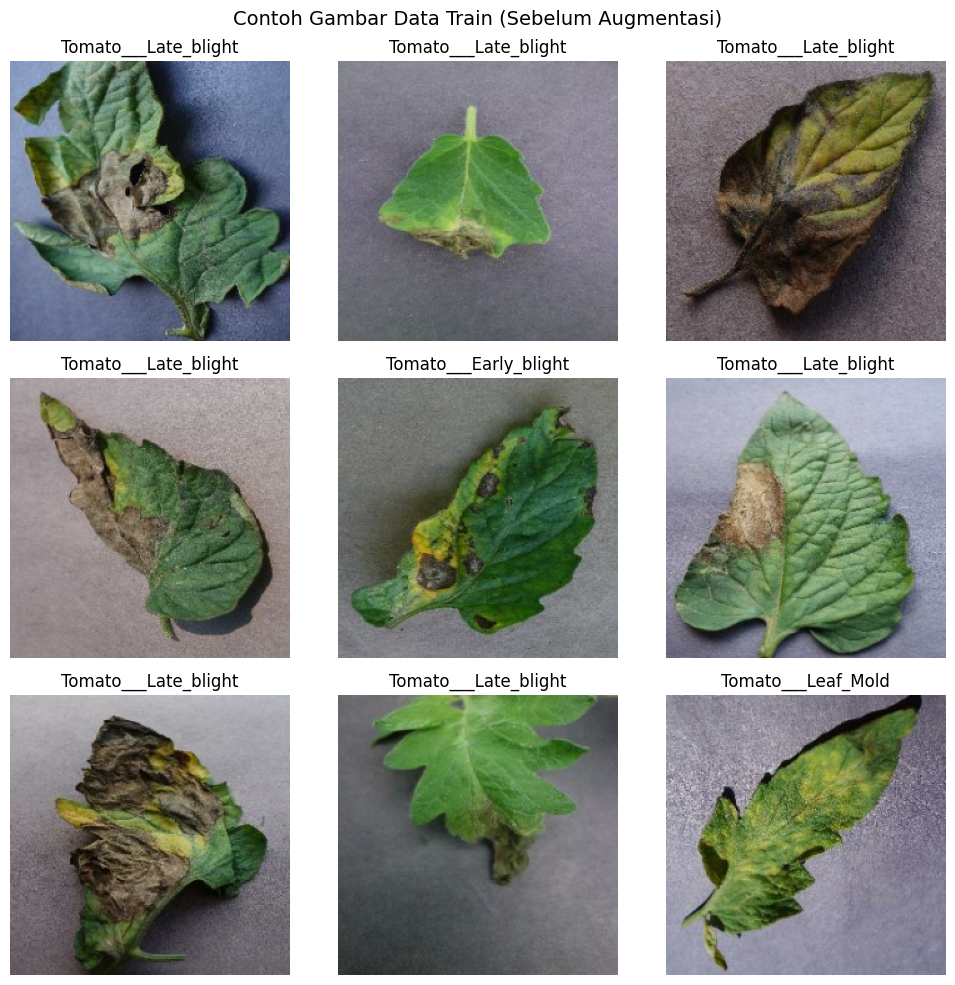

In [4]:
# Tampilkan sample gambar dari TRAIN (sebelum augmentasi)
# ============================

# Ambil batch pertama dari train dataset original (tanpa augmentasi)
raw_train = image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=9,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED
)

images, labels = next(iter(raw_train))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

plt.suptitle("Contoh Gambar Data Train (Sebelum Augmentasi)", fontsize=14)
plt.tight_layout()
plt.show()


In [5]:
# DATA AUGMENTATION + PREFETCH
# ===============================================================
import tensorflow.keras.layers as L

data_augmentation = tf.keras.Sequential([
    L.RandomFlip("horizontal"),
    L.RandomRotation(0.1),
    L.RandomZoom(0.12),
    L.RandomContrast(0.1)
])

AUTOTUNE = tf.data.AUTOTUNE

def prepare_for_training(ds, shuffle=True, augment=False):
    ds = ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(500, seed=SEED)
    return ds.cache().prefetch(AUTOTUNE)

train_ds = prepare_for_training(train_ds, shuffle=True, augment=True)
val_ds = prepare_for_training(val_ds, shuffle=False)
test_ds = prepare_for_training(test_ds, shuffle=False)

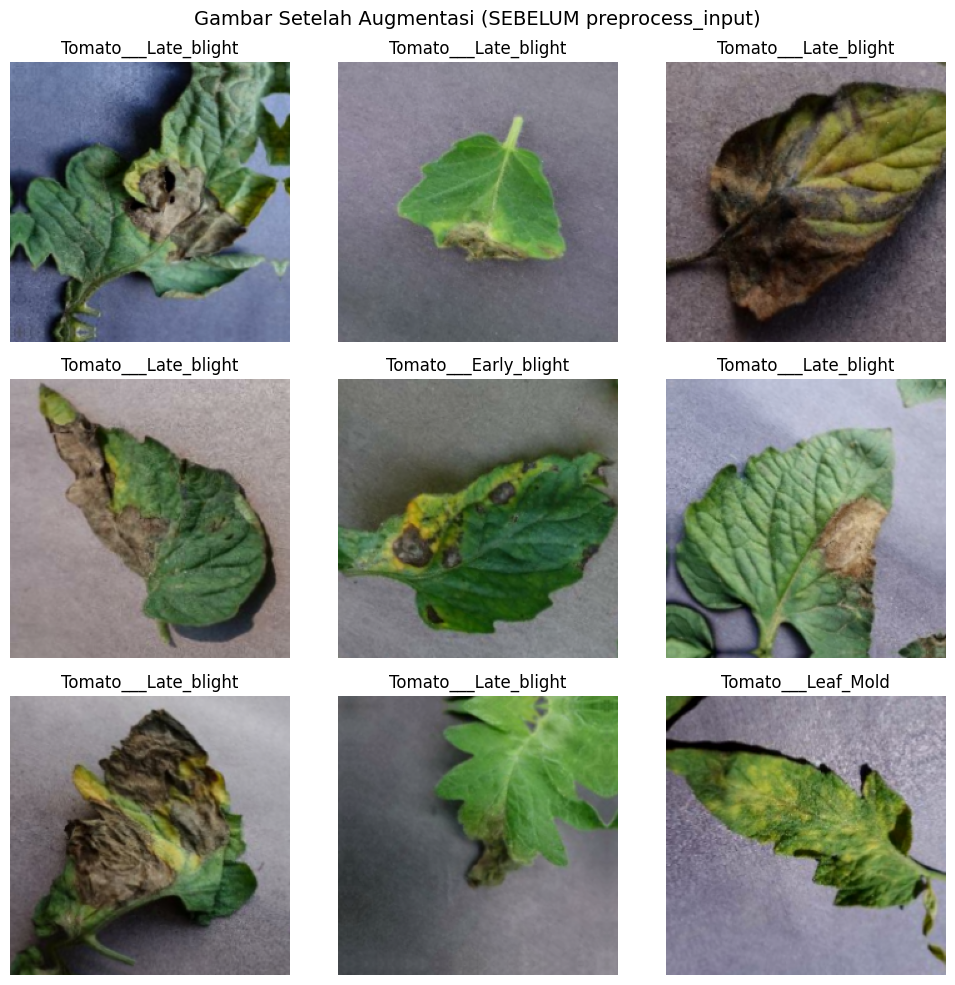

In [6]:

# ============================
# Tampilkan sample gambar setelah AUGMENTASI (sebelum preprocess_input)
# ============================

# Terapkan augmentasi pada batch yang sama
augmented_images = data_augmentation(images, training=True)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(tf.cast(augmented_images[i], tf.uint8).numpy())
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

plt.suptitle("Gambar Setelah Augmentasi (SEBELUM preprocess_input)", fontsize=14)
plt.tight_layout()
plt.show()




In [7]:
#tampilkan jumlah data setelah augmentasi
train_count = sum([len(os.listdir(os.path.join(train_dir, folder))) for folder in
                    os.listdir(train_dir)])
print("Jumlah data train setelah augmentasi:", train_count)
#tampilkan jumlah data train sebelum augmentasi
train_count_before = sum([len(os.listdir(os.path.join(train_dir, folder))) for folder in
                    os.listdir(train_dir)])
print("Jumlah data train sebelum augmentasi:", train_count_before)

Jumlah data train setelah augmentasi: 560
Jumlah data train sebelum augmentasi: 560


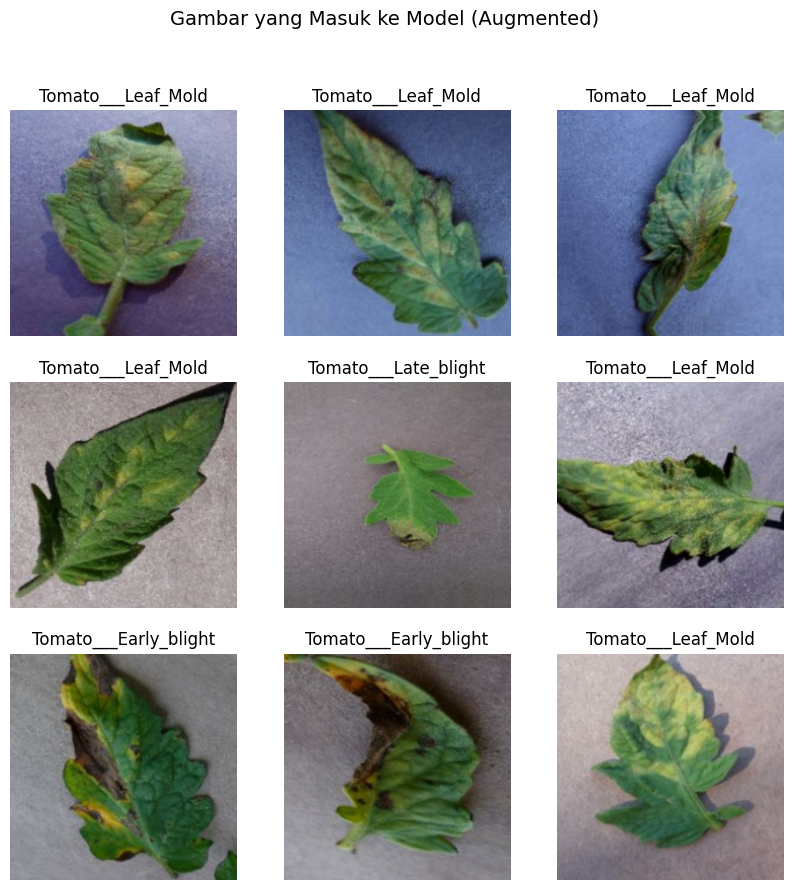

In [8]:
# ambil batch pertama dari train_ds (yang sudah augment)
aug_train_batch = next(iter(train_ds))

aug_imgs, aug_labels = aug_train_batch

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(tf.cast(aug_imgs[i], tf.uint8).numpy())
    plt.title(class_names[np.argmax(aug_labels[i])])
    plt.axis("off")

plt.suptitle("Gambar yang Masuk ke Model (Augmented)", fontsize=14)
plt.show()


In [9]:
# =============================================
# Callback untuk cek apakah augmentasi terjadi
# =============================================
class AugCheckCallback(tf.keras.callbacks.Callback):
    def on_train_batch_begin(self, batch, logs=None):
        if batch == 0:  # cek batch pertama saja
            imgs, lbls = self.model._train_counter_inputs
            print("\nContoh batch sebelum masuk model:")
            print(" - nilai min:", tf.reduce_min(imgs).numpy())
            print(" - nilai max:", tf.reduce_max(imgs).numpy())

            callbacks.append(AugCheckCallback())
            augmented_imgs = data_augmentation(imgs, training=True)
            print("Contoh batch setelah augmentasi:")
            print(" - nilai min:", tf.reduce_min(augmented_imgs).numpy())
            print(" - nilai max:", tf.reduce_max(augmented_imgs).numpy())
            # hanya cek sekali
            self.model.stop_training = True
            



In [10]:
# Hitung jumlah file asli di dataset
total_files = 0
for folder in os.listdir(train_dir):
    total_files += len(os.listdir(os.path.join(train_dir, folder)))

print("Jumlah data asli:", total_files)
print("Jumlah augmented sample per epoch:", total_files)


Jumlah data asli: 560
Jumlah augmented sample per epoch: 560


In [11]:
import math
total_batches = math.ceil(total_files / BATCH_SIZE)

print("Batch per epoch:", total_batches)
print("Augmented images per batch:", BATCH_SIZE)
print("Total augmented output per epoch:", total_batches * BATCH_SIZE)


Batch per epoch: 9
Augmented images per batch: 64
Total augmented output per epoch: 576


In [12]:
# MODEL: EfficientNetB0 + Fine Tuning
# ===============================================================
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

base_model.trainable = False  # freeze awal

inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = data_augmentation(inputs)
x = preprocess_input(x)

x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)

x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# Tambah dense layer opsional
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(
    optimizer=Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,383,655 (16.72 MB)

 Trainable params: 331,524 (1.26 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [ ]:
# CALLBACKS
# ===============================================================
os.makedirs("src", exist_ok=True)

callbacks = [
    ModelCheckpoint(
        "src/best_model.h5",
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=6,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]
callbacks.append(AugCheckCallback())




In [14]:
# TRAINING (STAGE 1 – Freezed Base Model)
# ===============================================================
EPOCHS = 40

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

# ===============================================================
# FINE TUNING – Unfreeze top layers EfficientNet
# ===============================================================
# buka 30 layer terakhir EfficientNet untuk fine-tuning
fine_tune_at = len(base_model.layers) - 30
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(1e-5), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("🔧 Fine-tuning mulai...")

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - accuracy: 0.2894 - loss: 2.0573

9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.3179 - loss: 1.9251 - val_accuracy: 0.4744 - val_loss: 1.1987 - learning_rate: 1.0000e-04
Epoch 2/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - accuracy: 0.4705 - loss: 1.4370

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 959ms/step - accuracy: 0.4946 - loss: 1.3584 - val_accuracy: 0.6795 - val_loss: 1.0575 - learning_rate: 1.0000e-04
Epoch 3/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - accuracy: 0.6257 - loss: 1.0323

9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6143 - loss: 1.0462 - val_accuracy: 0.7179 - val_loss: 0.9553 - learning_rate: 1.0000e-04
Epoch 4/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 979ms/step - accuracy: 0.6982 - loss: 0.8204 - val_accuracy: 0.7179 - val_loss: 0.8787 - learning_rate: 1.0000e-04
Epoch 5/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 956ms/step - accuracy: 0.7321 - loss: 0.6616 - val_accuracy: 0.7179 - val_loss: 0.8163 - learning_rate: 1.0000e-04
Epoch 6/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 718ms/step - accuracy: 0.7559 - loss: 0.6825

9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 974ms/step - accuracy: 0.7661 - loss: 0.6705 - val_accuracy: 0.7564 - val_loss: 0.7651 - learning_rate: 1.0000e-04
Epoch 7/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - accuracy: 0.8006 - loss: 0.5744

9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7982 - loss: 0.5564 - val_accuracy: 0.7628 - val_loss: 0.7213 - learning_rate: 1.0000e-04
Epoch 8/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 821ms/step - accuracy: 0.8103 - loss: 0.4886

9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8268 - loss: 0.5046 - val_accuracy: 0.7949 - val_loss: 0.6810 - learning_rate: 1.0000e-04
Epoch 9/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 808ms/step - accuracy: 0.8180 - loss: 0.4610

9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8125 - loss: 0.4883 - val_accuracy: 0.8013 - val_loss: 0.6430 - learning_rate: 1.0000e-04
Epoch 10/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.8459 - loss: 0.4294

9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8482 - loss: 0.4230 - val_accuracy: 0.8077 - val_loss: 0.6052 - learning_rate: 1.0000e-04
Epoch 11/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.8448 - loss: 0.4306

9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8411 - loss: 0.4298 - val_accuracy: 0.8141 - val_loss: 0.5683 - learning_rate: 1.0000e-04
Epoch 12/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.8939 - loss: 0.3386

9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8786 - loss: 0.3812 - val_accuracy: 0.8269 - val_loss: 0.5359 - learning_rate: 1.0000e-04
Epoch 13/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 803ms/step - accuracy: 0.8735 - loss: 0.3271

9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8750 - loss: 0.3281 - val_accuracy: 0.8333 - val_loss: 0.5070 - learning_rate: 1.0000e-04
Epoch 14/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - accuracy: 0.8939 - loss: 0.3327

9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8875 - loss: 0.3339 - val_accuracy: 0.8526 - val_loss: 0.4799 - learning_rate: 1.0000e-04
Epoch 15/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - accuracy: 0.8768 - loss: 0.3239

9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8732 - loss: 0.3516 - val_accuracy: 0.8718 - val_loss: 0.4523 - learning_rate: 1.0000e-04
Epoch 16/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step - accuracy: 0.8899 - loss: 0.2804

9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8982 - loss: 0.2799 - val_accuracy: 0.8846 - val_loss: 0.4265 - learning_rate: 1.0000e-04
Epoch 17/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 787ms/step - accuracy: 0.9264 - loss: 0.2175

9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9071 - loss: 0.2655 - val_accuracy: 0.8910 - val_loss: 0.4035 - learning_rate: 1.0000e-04
Epoch 18/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.9092 - loss: 0.2392

9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9018 - loss: 0.2474 - val_accuracy: 0.8974 - val_loss: 0.3834 - learning_rate: 1.0000e-04
Epoch 19/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 978ms/step - accuracy: 0.9018 - loss: 0.2585 - val_accuracy: 0.8974 - val_loss: 0.3661 - learning_rate: 1.0000e-04
Epoch 20/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 965ms/step - accuracy: 0.9339 - loss: 0.1925 - val_accuracy: 0.8974 - val_loss: 0.3490 - learning_rate: 1.0000e-04
Epoch 21/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - accuracy: 0.8786 - loss: 0.2934

9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9071 - loss: 0.2504 - val_accuracy: 0.9038 - val_loss: 0.3345 - learning_rate: 1.0000e-04
Epoch 22/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.9274 - loss: 0.1916

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 937ms/step - accuracy: 0.9250 - loss: 0.2104 - val_accuracy: 0.9103 - val_loss: 0.3219 - learning_rate: 1.0000e-04
Epoch 23/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 700ms/step - accuracy: 0.9308 - loss: 0.1971

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 945ms/step - accuracy: 0.9214 - loss: 0.2147 - val_accuracy: 0.9167 - val_loss: 0.3115 - learning_rate: 1.0000e-04
Epoch 24/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.9108 - loss: 0.2129

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 929ms/step - accuracy: 0.9089 - loss: 0.2279 - val_accuracy: 0.9231 - val_loss: 0.3024 - learning_rate: 1.0000e-04
Epoch 25/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 892ms/step - accuracy: 0.9125 - loss: 0.2174 - val_accuracy: 0.9231 - val_loss: 0.2905 - learning_rate: 1.0000e-04
Epoch 26/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 892ms/step - accuracy: 0.9161 - loss: 0.2424 - val_accuracy: 0.9231 - val_loss: 0.2793 - learning_rate: 1.0000e-04
Epoch 27/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 914ms/step - accuracy: 0.9250 - loss: 0.2037 - val_accuracy: 0.9231 - val_loss: 0.2702 - learning_rate: 1.0000e-04
Epoch 28/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 897ms/step - accuracy: 0.9411 - loss: 0.1632 - val_accuracy: 0.9231 - val_loss: 0.2613 - learning_rate: 1.0000e-04
Epoch 29/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.9599 - loss: 0.1476

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 929ms/step - accuracy: 0.9536 - loss: 0.1387 - val_accuracy: 0.9295 - val_loss: 0.2528 - learning_rate: 1.0000e-04
Epoch 30/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 902ms/step - accuracy: 0.9482 - loss: 0.1562 - val_accuracy: 0.9295 - val_loss: 0.2463 - learning_rate: 1.0000e-04
Epoch 31/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 904ms/step - accuracy: 0.9518 - loss: 0.1497 - val_accuracy: 0.9295 - val_loss: 0.2410 - learning_rate: 1.0000e-04
Epoch 32/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 893ms/step - accuracy: 0.9482 - loss: 0.1527 - val_accuracy: 0.9295 - val_loss: 0.2336 - learning_rate: 1.0000e-04
Epoch 33/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 928ms/step - accuracy: 0.9429 - loss: 0.1658 - val_accuracy: 0.9295 - val_loss: 0.2284 - learning_rate: 1.0000e-04
Epoch 34/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 740ms/step - accuracy: 0.9465 - loss: 0.1721

9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9429 - loss: 0.1649 - val_accuracy: 0.9359 - val_loss: 0.2235 - learning_rate: 1.0000e-04
Epoch 35/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 748ms/step - accuracy: 0.9491 - loss: 0.1342

9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9536 - loss: 0.1298 - val_accuracy: 0.9423 - val_loss: 0.2198 - learning_rate: 1.0000e-04
Epoch 36/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 907ms/step - accuracy: 0.9357 - loss: 0.1604 - val_accuracy: 0.9423 - val_loss: 0.2145 - learning_rate: 1.0000e-04
Epoch 37/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 899ms/step - accuracy: 0.9607 - loss: 0.1241 - val_accuracy: 0.9423 - val_loss: 0.2090 - learning_rate: 1.0000e-04
Epoch 38/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 913ms/step - accuracy: 0.9554 - loss: 0.1427 - val_accuracy: 0.9423 - val_loss: 0.2025 - learning_rate: 1.0000e-04
Epoch 39/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 909ms/step - accuracy: 0.9464 - loss: 0.1678 - val_accuracy: 0.9423 - val_loss: 0.1983 - learning_rate: 1.0000e-04
Epoch 40/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 921ms/step - accuracy: 0.9536 - loss: 0.1296 - val_accuracy: 0.9359 - val_loss: 0.1974 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 40.
🔧 Fine-tuning mulai...
Ep

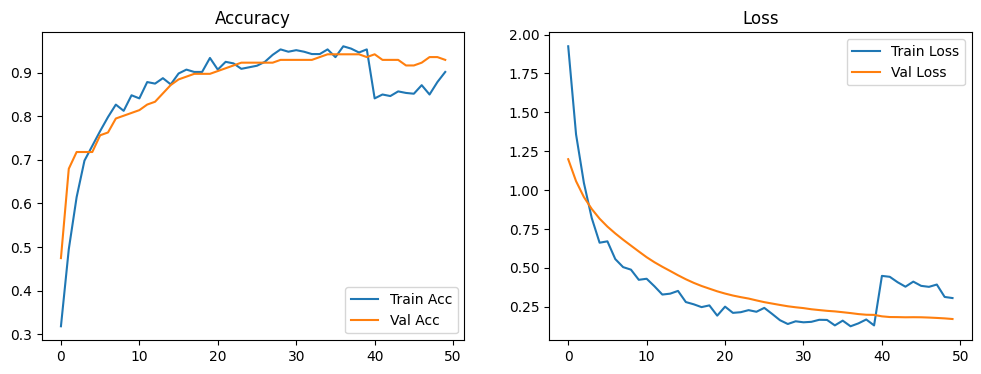

In [15]:
# PLOTTING
# ===============================================================
acc = history.history['accuracy'] + history_finetune.history['accuracy']
val_acc = history.history['val_accuracy'] + history_finetune.history['val_accuracy']
loss = history.history['loss'] + history_finetune.history['loss']
val_loss = history.history['val_loss'] + history_finetune.history['val_loss']

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.title("Loss")

plt.show()

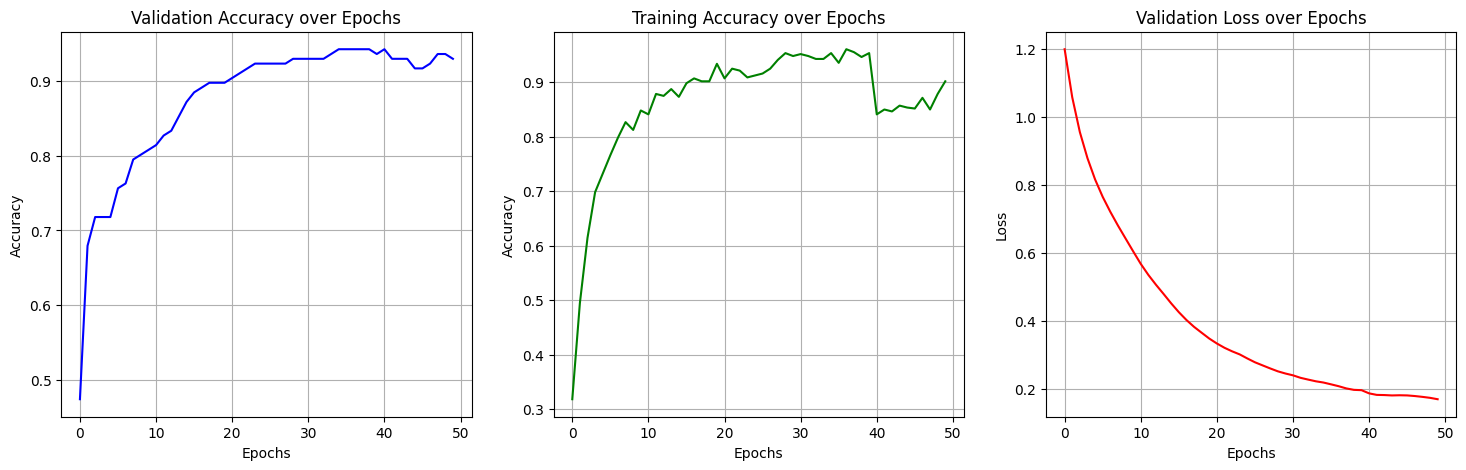

In [16]:
# PLOTTING validation, training dan testing

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(val_acc, label='Validation Accuracy', color='blue')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.subplot(1, 3, 2)
plt.plot(acc, label='Training Accuracy', color='green')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.subplot(1, 3, 3)
plt.plot(val_loss, label='Validation Loss', color='red')
plt.title('Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.show()




2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step


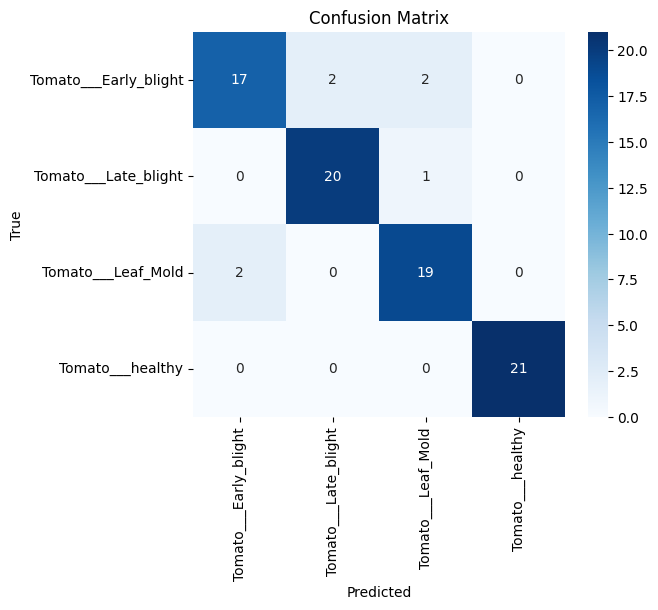


Classification Report:

                       precision    recall  f1-score   support

Tomato___Early_blight       0.89      0.81      0.85        21
 Tomato___Late_blight       0.91      0.95      0.93        21
   Tomato___Leaf_Mold       0.86      0.90      0.88        21
     Tomato___healthy       1.00      1.00      1.00        21

             accuracy                           0.92        84
            macro avg       0.92      0.92      0.92        84
         weighted avg       0.92      0.92      0.92        84

Akurasi Test: 91.67%


In [17]:
# EVALUASI – TEST DATA
# ===============================================================
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
if y_true.ndim == 2:
    y_true = np.argmax(y_true, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

acc_train = (y_pred == y_true).mean() * 100
print(f"Akurasi Test: {acc_train:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 514ms/step


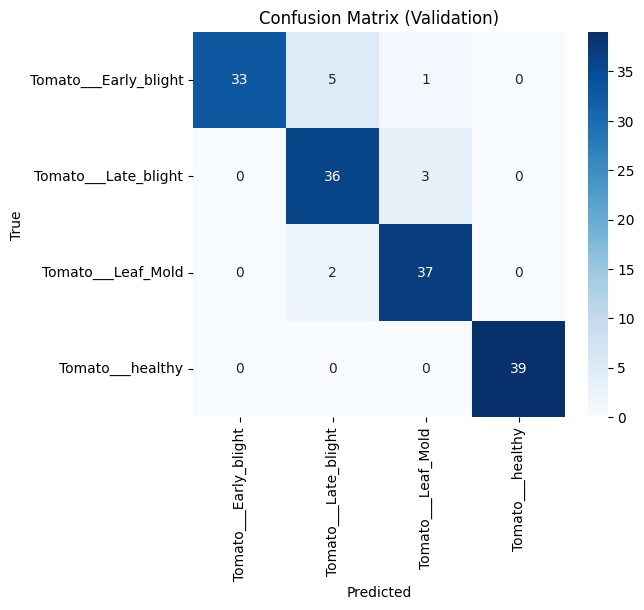


Classification Report (Validation):

                       precision    recall  f1-score   support

Tomato___Early_blight       1.00      0.85      0.92        39
 Tomato___Late_blight       0.84      0.92      0.88        39
   Tomato___Leaf_Mold       0.90      0.95      0.93        39
     Tomato___healthy       1.00      1.00      1.00        39

             accuracy                           0.93       156
            macro avg       0.93      0.93      0.93       156
         weighted avg       0.93      0.93      0.93       156

Akurasi Val: 92.95%


In [18]:
# evaluasi data validation
y_val_probs = model.predict(val_ds)
y_val = np.argmax(y_val_probs, axis=1)  # use y_val_probs, not y_pred_probs

# kumpulkan label asli dari val_ds
y_true = np.concatenate([y.numpy() for _, y in val_ds], axis=0)
if y_true.ndim == 2:
    y_true = np.argmax(y_true, axis=1)

# jika terjadi ketidaksamaan panjang, potong ke panjang minimum agar tidak error
if y_val.shape[0] != y_true.shape[0]:
    print(f"Warning: mismatch lengths y_val={y_val.shape[0]}, y_true={y_true.shape[0]}. Truncating to min length.")
    m = min(y_val.shape[0], y_true.shape[0])
    y_val = y_val[:m]
    y_true = y_true[:m]

cm = confusion_matrix(y_true, y_val)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nClassification Report (Validation):\n")
print(classification_report(y_true, y_val, target_names=class_names))

acc_val = (y_val == y_true).mean() * 100
print(f"Akurasi Val: {acc_val:.2f}%")


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 724ms/step


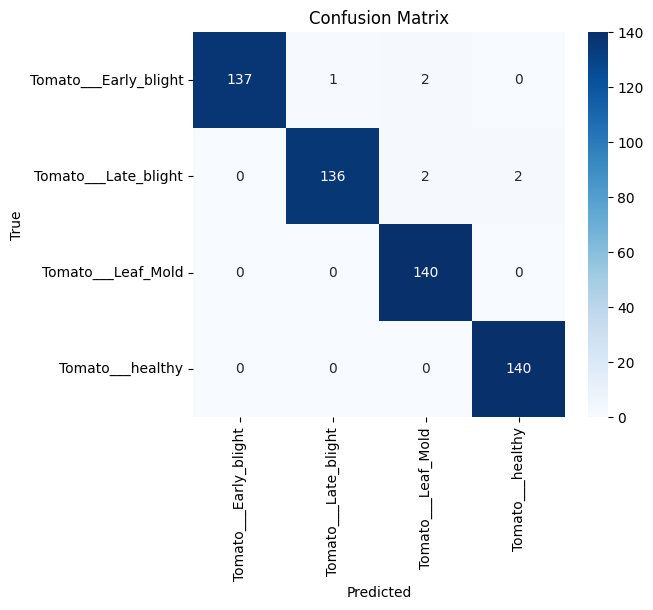


Classification Report:

                       precision    recall  f1-score   support

Tomato___Early_blight       1.00      0.98      0.99       140
 Tomato___Late_blight       0.99      0.97      0.98       140
   Tomato___Leaf_Mold       0.97      1.00      0.99       140
     Tomato___healthy       0.99      1.00      0.99       140

             accuracy                           0.99       560
            macro avg       0.99      0.99      0.99       560
         weighted avg       0.99      0.99      0.99       560

Akurasi Train: 98.75%


In [19]:
# EVALUASI – TRAIN
y_pred_probs = model.predict(train_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.concatenate([y.numpy() for _, y in train_ds], axis=0)
if y_true.ndim == 2:
    y_true = np.argmax(y_true, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

acc_test = (y_pred == y_true).mean() * 100
print(f"Akurasi Train: {acc_test:.2f}%")

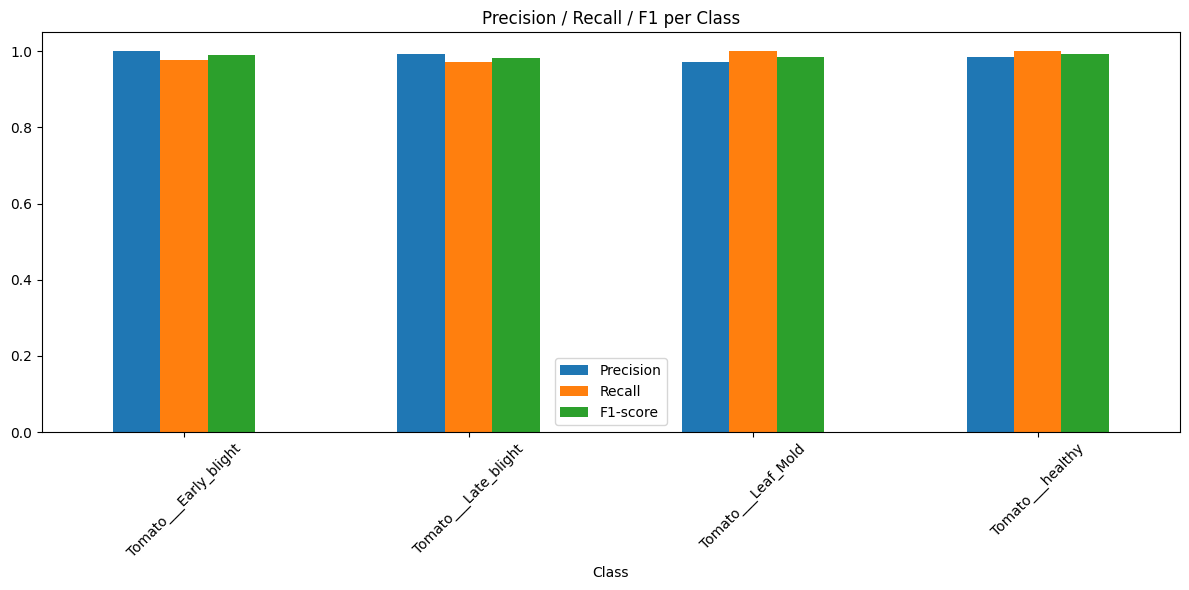

In [20]:
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd

precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, labels=range(len(class_names))
)

eval_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1,
    'Support': support
})




# Jika ingin precision dan recall juga
eval_df.plot(x="Class", y=["Precision", "Recall", "F1-score"], kind="bar", figsize=(12, 6))
plt.title("Precision / Recall / F1 per Class")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
